In [1]:
import os
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], "src"))

## init combined robot config

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *

crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, None,
                INDY_IP)]
              , connection_list=[False])

connection_list
[False]


## create scene builder

In [3]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None, base_link="base_link")
# s_builder.reset_reference_coord(ref_name="floor")

## get ghnd with detected robot config

In [4]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,-np.pi/2))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


## add environment

In [5]:
from pkg.geometry.geometry import *

In [6]:
floor = gscene.create_safe(GEOTYPE.BOX, "floor", "base_link", (3,3,0.01), (0,0,0), 
                           rpy=(0,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
wall = gscene.create_safe(GEOTYPE.BOX, "wall", "base_link", (3,3,0.01), (0,0.2,0), 
                           rpy=(np.pi/2,0,0), color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=True)
wp1 = gscene.create_safe(GEOTYPE.BOX, "wp1", "base_link", (0.1,0.1,0.01), (0.2,-0.5,0.),rpy=(0,0,np.pi/2), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False)
wp2 = gscene.create_safe(GEOTYPE.BOX, "wp2", "base_link", (0.1,0.1,0.01), (-0.2,-0.5,0), rpy=(0,0,np.pi/2), 
                         color=(0.8,0.2,0.2,1), display=True, fixed=True, collision=False)
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (0.1,0.5,0.01), (0,-0.5,0), rpy=(0,0,np.pi/2), 
                           color=(1,0.7,0.7,0.5), display=True, fixed=True, collision=False)
goal = gscene.create_safe(GEOTYPE.BOX, "goal", "base_link", (0.1,0.1,0.01), (-0.4,-0.3,0), 
                          rpy=(0,0,0), color=(0.8,0.8,0.2,1), display=True, fixed=True, collision=False)

Please create a subscriber to the marker


In [7]:
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True, exclude_link=["panda1_link7"])

## add brush

In [8]:
brush_body = gscene.create_safe(gtype=GEOTYPE.BOX, name="brush_body", link_name="base_link", 
                                dims=(0.2,0.07,0.02), center=(0.0,-0.5,0.045), rpy=(0,0,np.pi/2), 
                                color=(0.7,0.7,0.3,1), display=True, collision=True, fixed=False)
brush_handle = gscene.create_safe(gtype=GEOTYPE.BOX, name="brush_handle", link_name="base_link", 
                                  dims=(0.2,0.03,0.05), center=(0,0,0.035), rpy=(0,0,0), 
                                  color=(0.7,0.7,0.3,1), display=True, collision=True, fixed=False, parent="brush_body")
brush_face = gscene.create_safe(gtype=GEOTYPE.BOX, name="brush_face", link_name="base_link", 
                                dims=(0.19,0.06,0.03), center=(0,0,-0.025), rpy=(0,0,0), 
                                color=(0.8,0.8,0.8,1), display=True, collision=False, fixed=False, parent="brush_body")

## init planning scene

In [9]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

## Register binders

In [10]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepTool

In [11]:
gscene.create_safe(gtype=GEOTYPE.SPHERE, name="grip0", link_name="indy0_tcp", 
                 dims=(0.01,)*3, center=(0,0,0.14), rpy=(-np.pi/2,0,0), color=(1,0,0,1), display=True, collision=False, fixed=True)

In [12]:
pscene.create_binder(bname="grip0", gname="grip0", rname="indy0", _type=Gripper2Tool, point=(0,0,0), rpy=(0,0,0))
pscene.create_binder(bname="floor", gname="floor", _type=PlacePlane)
pscene.create_binder(bname="goal_bd", gname="goal", _type=PlacePlane, point=(0,0,0.005), rpy=(0,0,0))
pscene.create_binder(bname="brush_face", gname="brush_face", _type=SweepTool, point=(0,0,-0.015), rpy=(0,0,0))

## add objects

In [13]:
from pkg.planning.constraint.constraint_subject import CustomObject, Grasp2Point, PlacePoint, SweepPoint, SweepTask

In [14]:
brush_handle = gscene.NAME_DICT["brush_handle"]
brush_face = gscene.NAME_DICT["brush_face"]
brush = pscene.create_object(oname="brush", gname="brush_body", _type=CustomObject, 
                             action_points_dict = {"handle": Grasp2Point("handle", brush_handle, [0,0,0], [np.pi/2,0,0]),
                                                   "face": PlacePoint("face", brush_face, [0,0,-0.015], [0,0,0])})

In [15]:
sweep = pscene.create_object(oname="sweep", gname="floor", _type=SweepTask, 
                             action_points_dict = {"wp1": SweepPoint("wp1", wp1, [0,0,0.005], [0,0,0]),
                                                   "wp2": SweepPoint("wp2", wp2, [0,0,0.005], [0,0,0])})

## Set test scenario

In [16]:
from pkg.planning.constraint.constraint_common import combine_redundancy, sample_redundancy, calc_redundancy
import random

actor = pscene.actor_dict["grip0"]
obj = pscene.subject_dict["brush"]
handle = obj.action_points_dict["handle"]
redundancy_tot = combine_redundancy(handle, actor)
redundancy = sample_redundancy(redundancy_tot, sampler=random.uniform)
redundancy['grip0']['w'] = np.deg2rad(0)
redundancy['handle']['w'] = np.deg2rad(0)
redundancy_values = {}
redundancy_values[(obj.oname, handle.name)] = calc_redundancy(redundancy[handle.name], handle)
redundancy_values[(obj.oname, actor.name)] = calc_redundancy(redundancy[actor.name], actor)
Q_dict = crob.home_dict

## Grasp checker

In [17]:
from pkg.planning.filtering.grasp_filter import GraspChecker
gcheck = GraspChecker(pscene, end_link_couple_dict= {"indy0_tcp": ["indy0_tcp", "indy0_link6"], "base_link":["base_link"]})

## grasp check

In [18]:
gtimer = GlobalTimer.instance()
gtimer.reset()

for _ in range(1000):    
    with gtimer.block("check"):
        res = gcheck.check(actor, obj, handle, redundancy_values, Q_dict)
print(res)
print(gtimer)

True
check: 	408.0 ms/1000 = 0.408 ms (0.393/0.71)



In [19]:
from pkg.planning.motion.moveit.moveit_py import CartPose
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
# mplan = MoveitPlanner(pscene, [gcheck, rcheck, lcheck])
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
chain_dict = pscene.get_robot_chain_dict()
binder_links = [chain_dict[rname]['tip_link'] for rname in crob.robot_names]
binder_link_robot_dict = {blink: rname for blink, rname in zip(binder_links, crob.robot_names)}

In [20]:
gtimer.reset()
with gtimer.block("preproc"):
    actor_link = actor.geometry.link_name
    object_link = obj.geometry.link_name

    point_add_handle, rpy_add_handle = redundancy_values[(obj.oname, handle.name)]
    point_add_actor, rpy_add_actor = redundancy_values[(obj.oname, actor.name)]

    T_handle_lh = np.matmul(handle.Toff_lh, SE3(Rot_rpy(rpy_add_handle), point_add_handle))
    T_actor_lh = np.matmul(actor.Toff_lh, SE3(Rot_rpy(rpy_add_actor), point_add_actor))
    
    group_name_handle = binder_link_robot_dict[handle.geometry.link_name] if handle.geometry.link_name in binder_link_robot_dict else None
    group_name_actor = binder_link_robot_dict[actor.geometry.link_name] if actor.geometry.link_name in binder_link_robot_dict else None

    if group_name_actor and not group_name_handle:
        group_name = group_name_actor
        T_handle_link = get_tf(object_link, Q_dict, pscene.gscene.urdf_content)
        T_link_handle_actor_link = np.matmul(T_handle_lh, SE3_inv(T_actor_lh))
        T_tar = np.matmul(T_handle_link, T_link_handle_actor_link)
    elif group_name_handle and not group_name_actor:
        group_name = group_name_handle
        T_actor_link = get_tf(actor_link, Q_dict, pscene.gscene.urdf_content)
        T_link_actor_handle_link = np.matmul(T_actor_lh, SE3_inv(T_actor_link))
        T_tar = np.matmul(T_actor_link, T_link_actor_handle_link)        
    goal_pose = tuple(T_tar[:3,3]) \
                +tuple(Rotation.from_dcm(T_tar[:3,:3]).as_quat())
print(gtimer)

preproc: 	0.0 ms/1 = 0.433 ms (0.433/0.433)



In [23]:
radius_min=0.2
radius_max=1
theta_min=-np.pi
theta_max=np.pi
height_min=-0.5
height_max=1.3
zenith_min=0
zenith_max=np.pi
azimuth_min=-np.pi
azimuth_max=np.pi
gtimer.reset()

In [35]:
gtimer.reset()
ik_list = []
gjk_list = []
for _ in range(1000):
    radius = random.uniform(radius_min, radius_max)
    theta = random.uniform(theta_min, theta_max)
    height = random.uniform(height_min, height_max)
    azimuth_loc = random.uniform(azimuth_min, azimuth_max)
    zenith = random.uniform(zenith_min, zenith_max)
    xyz = cyl2cart(radius, theta, height)
    quat = tuple(Rotation.from_dcm(hori2mat(theta, azimuth_loc, zenith)).as_quat())
    goal_pose = xyz+quat

    with gtimer.block("solve_ik", stack=True):
        res_ik = mplan.planner.solve_ik(group_name, CartPose(*goal_pose), 0.1, 1.0, False, False)
    res_py = np.array([res_ik[i] for i in range(len(res_ik))], dtype=np.float16)
    found = np.sum(np.abs(res_py)) > 1e-4;
    res_gjk = False
    if found:
        with gtimer.block("gjk_self", stack=True):
            res_gjk = mplan.planner.check_collision(True)
    ik_list.append(found)
    gjk_list.append(not res_gjk)
    
print(gtimer)

solve_ik: 	49452.0 ms/1000 = 49.452 ms (0.052/102.489)
gjk_self: 	17.0 ms/513 = 0.033 ms (0.017/0.081)



1.3646489230745253


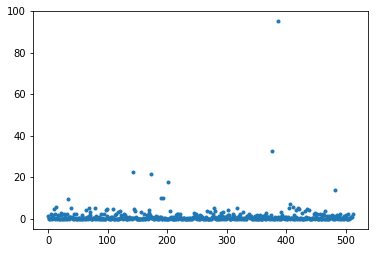

In [38]:
plt.plot(np.array(gtimer.timelist_dict['solve_ik'])[np.where(ik_list)], '.')
print(np.mean(np.array(gtimer.timelist_dict['solve_ik'])[np.where(ik_list)]))

0.03290873521949813


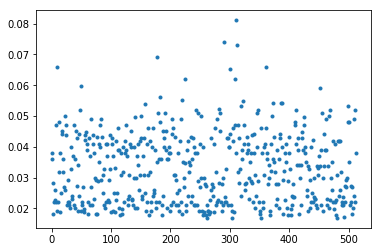

In [39]:
plt.plot(np.array(gtimer.timelist_dict['gjk_self']), '.')
print(np.mean(np.array(gtimer.timelist_dict['gjk_self'])))

In [99]:
gscene.show_pose(res_py)

## Reach SVM

In [19]:
from pkg.planning.filtering.reach_filter import ReachChecker
rcheck = ReachChecker(pscene)

## reach check

In [20]:
gtimer = GlobalTimer.instance()
gtimer.reset()

for _ in range(1000):    
    with gtimer.block("check"):
        res = rcheck.check(actor, obj, handle, redundancy_values, Q_dict)
print(res)
print(gtimer)

True
check: 	162.0 ms/1000 = 0.162 ms (0.151/0.403)



## Latticized Filter

In [21]:
from pkg.planning.filtering.latticized_filter import LatticedChecker
lcheck = LatticedChecker(pscene, end_link_couple_dict= {"indy0_tcp": ["indy0_tcp", "indy0_link6"], "base_link":["base_link"]})

## latticize and check

In [22]:
gtimer = GlobalTimer.instance()
gtimer.reset()

for _ in range(10):    
    with gtimer.block("check"):
        res = lcheck.check(actor, obj, handle, redundancy_values, Q_dict)
print(res)
print(gtimer)

True
check: 	347.0 ms/10 = 34.732 ms (30.47/50.19)



## actual plan

In [23]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()

In [24]:
initial_state = pscene.update_state(crob.home_pose)
grasp_state = initial_state.copy(pscene)
grasp_state.set_binding_state((('brush', 'handle', 'grip0', 'grip0'), ('sweep', None, None, None)), pscene)
redundancy_dict = {"brush": redundancy}

In [25]:
Traj, LastQ, error, success, binding_list = mplan.plan_transition(initial_state, grasp_state, 
                                                                  redundancy_dict=redundancy_dict, timeout=5)
print(success)

True


In [26]:
gscene.show_motion(Traj)

In [27]:
gscene.show_pose(Traj[-1])

### planning pipeline

In [23]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
# mplan = MoveitPlanner(pscene, [gcheck, rcheck, lcheck])
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.object_a_star import ObjectAstar
tplan = ObjectAstar(pscene)
tplan.prepare()
from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)
ppline.set_motion(mplan)
ppline.set_sampler(tplan)

## ui

In [24]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
generate table - Geometry
generate table - Handle
generate table - Binder
 generate table - Object


## Test plan

In [30]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy

initial_state = pscene.update_state(crob.home_pose)

   Use a production WSGI server instead.
 * Debug mode: off


In [31]:
mplan.reset_log(True)
# goal_nodes = [("goal",)]
goal_nodes = [("goal", 2)]
ppline.search(initial_state, goal_nodes, verbose=True, display=True, dt_vis=0.01, timeout_loop=300, multiprocess=False, timeout=1)
schedules = ppline.find_schedules()
schedules_sorted = ppline.sort_schedule(schedules)
snode_schedule = ppline.idxSchedule2SnodeScedule(schedules_sorted[0])

AttributeError: PlanningPipeline instance has no attribute 'snode_counter'

In [32]:
ppline.play_schedule(snode_schedule, period=0.01)

In [33]:
print(gtimer)

test_transition: 	3148.0 ms/7 = 449.768 ms (0.164/2571.933)
GraspChecker: 	3.0 ms/5 = 0.507 ms (0.402/0.692)
ReachChecker: 	1.0 ms/4 = 0.289 ms (0.245/0.417)
LatticedChecker: 	138.0 ms/4 = 34.601 ms (32.107/40.53)
planning: 	162.0 ms/4 = 40.418 ms (15.651/95.201)



In [34]:
mplan.result_log

{'GraspChecker': [False, True, True, True, True],
 'LatticedChecker': [True, True, True, True],
 'ReachChecker': [True, True, True, True],
 'planning': [True, True, True, True]}

## Text execution

In [21]:
# crob.reset_connection([True])

connection_list
[True]
Connect: Server IP (192.168.0.63)


## unsynced execution

In [23]:
ppline.execute_schedule(snode_schedule, vel_scale=0.5)

binder: floor
rname: None
binder: None
grasp_dict
{'indy0': False}
grasp_seq
[('indy0', False)]
Connect: Server IP (192.168.0.63)
binder: floor
rname: None
binder: None
grasp_dict
{'indy0': False}
grasp_seq
[('indy0', False)]
Connect: Server IP (192.168.0.63)
go
Connect: Server IP (192.168.0.63)
binder: grip0
rname: indy0
binder: None
grasp_dict
{'indy0': True}
grasp_seq
[('indy0', True)]
Connect: Server IP (192.168.0.63)
go
Connect: Server IP (192.168.0.63)
binder: grip0
rname: indy0
binder: brush_face
rname: None
grasp_dict
{'indy0': True}
grasp_seq
[('indy0', True)]
Connect: Server IP (192.168.0.63)
go
Connect: Server IP (192.168.0.63)
binder: grip0
rname: indy0
binder: brush_face
rname: None
grasp_dict
{'indy0': True}
grasp_seq
[('indy0', True)]
Connect: Server IP (192.168.0.63)
go
Connect: Server IP (192.168.0.63)
binder: goal_bd
rname: None
binder: brush_face
rname: None
grasp_dict
{'indy0': False}
grasp_seq
[('indy0', False)]
Connect: Server IP (192.168.0.63)
go
Connect: Server 

## synced execution

In [ ]:
## 
# with RvizPublisher(gscene, []) as rpub:
#     ppline.execute_schedule(snode_schedule, rviz_pub=rpub)

## Disconnect stereo

In [ ]:
stereo.disconnnect()